## Word2Vec on papers

Code reference from udacity tutorial on word2vec.
https://github.com/rndbrtrnd/udacity-deep-learning/blob/master/5_word2vec.ipynb

----

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import timeit
import codecs
import re
import os
from bs4 import BeautifulSoup # $ pip install beautifulsoup4
from wordcloud import WordCloud
import time

In [3]:
cleaned_paper_df = pd.read_csv('../dataset/cleaned_papers_pdf.csv',encoding='utf-8')

In [4]:
print(cleaned_paper_df.shape)
cleaned_paper_df.head()

(1042, 5)


,name,content,directory,isValid,faculty
0,Alice Sharp,Discarded appendicularian houses as sources of...,../papers/BIO/Alice Sharp/0014.pdf,True,BIO
1,Alice Sharp,AbstractThailandhassufferedfromseveredefor- es...,../papers/BIO/Alice Sharp/00463529693fc4921900...,True,BIO
2,Alice Sharp,"Cell, Vol. 11, 263-271, June 1977. Copyright 0...",../papers/BIO/Alice Sharp/0deec5230a91912b3800...,True,BIO
3,Alice Sharp,ImprovingthesolidwastemanagementinPhnomPenhcit...,../papers/BIO/Alice Sharp/1-s2.0-S0956053X0400...,True,BIO
4,Alice Sharp,arXiv:1001.2574v2 [astro-ph.CO] 26 Jan 2010Pro...,../papers/BIO/Alice Sharp/1001.2574,True,BIO


In [5]:
# Import various modules for string cleaning
from nltk.corpus import stopwords

def review_to_wordlist( paper_content ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", paper_content) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))      
    stops.add('cid')
    stops.add('de')
    stops.add('al')
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    
    # 5. Cut word with only 1 character except a,i,u
  
    meaningful_words = [w for w in meaningful_words if len(w)!=1 or w in['a','i','u']]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [6]:
# Download the punkt tokenizer for sentence splitting  
import nltk
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from nltk.corpus import stopwords # Import the stop word list
# Define a function to split a review into parsed sentences
def paper_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [7]:
%%time
#TODO: Check how much time is increase when insert printing
sentences = []  # Initialize an empty list of sentences
print("Parsing sentences from training set")
for i,paper in enumerate(cleaned_paper_df["content"]):
    if i%100==0: print("Reading row #%s"%str(i),end='\r') 
    sentences += paper_to_sentences(paper, tokenizer)
print("Finished parsing")


Parsing sentences from training set
Finished parsing0
Wall time: 2min 34s


In [8]:
%%time
split_sentences = [sentence.split(" ") for sentence in sentences if len(sentence)>1]
print("Finish splitting")

Finish splitting
Wall time: 982 ms


In [9]:
%%time
words = []
for sentence in split_sentences:
    words.extend(sentence)


Wall time: 212 ms


In [10]:
%%time
vocabulary_size = 300000

def build_dataset(sentences):
    print("Starting..")
    count = [['UNK', -1]]
    start_time = time.time()    
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    elapsed_time = time.time() - start_time
    print("Finished in "+str(elapsed_time))
    dictionary = dict()
    #Indexing word to a number
    for word, _ in count:
        dictionary[word] = len(dictionary) #A coding trick. (Length always increase, new word has +1)
        data = list()
        unk_count = 0
        
    l = len(sentences)
    for i,sentence in enumerate(sentences):
        print("Rows #%d / %d"%(i,l),end='\r')
        for word in sentence:
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

Wall time: 0 ns


In [11]:
%%time
print("HEY")
data, count, dictionary, reverse_dictionary = build_dataset(split_sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
#del split_sentences  # Hint to reduce memory.

HEY
Starting..
Finished in 1.7067103385925293
Most common words (+UNK) [['UNK', 239861], ('figure', 11299), ('system', 10059), ('time', 9989), ('table', 9627)]
Sample data [5567, 12866, 3824, 575, 214, 232, 44760, 7157, 1658, 1784]
Wall time: 44.2 s


In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['discarded', 'appendicularian', 'houses', 'sources', 'food', 'surface', 'habitats', 'particulate']

with num_skips = 2 and skip_window = 1:
    batch: ['appendicularian', 'appendicularian', 'houses', 'houses', 'sources', 'sources', 'food', 'food']
    labels: ['houses', 'discarded', 'sources', 'appendicularian', 'food', 'houses', 'surface', 'sources']

with num_skips = 4 and skip_window = 2:
    batch: ['houses', 'houses', 'houses', 'houses', 'sources', 'sources', 'sources', 'sources']
    labels: ['appendicularian', 'sources', 'food', 'discarded', 'appendicularian', 'food', 'houses', 'surface']


In [13]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [14]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 6.443103
Nearest to rate: canaccessfuturecommunicationsbydiscoveringthenext, voiceless, loch, metriciscomparingthecandidateandtherefer, limitedtoanacceptablelevel, functionsinlemma, asapseudostatefeedback, cshowthe,
Nearest to well: agreementwiththetheoreticalpredictions, mattei, knowledgeandinformationsystems, classes, gazetteersandcontextpatterns, deposit, undercutsandovercutsaredifferentiated, pflanzen,
Nearest to technology: methodsandstatisticaltest, althoughwehavealsomadesomeinitialtheoreticalprogressinautomaticallycalibratingthe, includingme, sor, highlights, sideredasa, objectsintherepresentation, kralsx,
Nearest to new: semanticswithprimi, tendstoinnity, anoptimizedversion, recallisanother, whilea, sukharevsky, fromthesi, nonlinearanal,
Nearest to one: itscompu, secondquantitywestudyisthestationaryoverowprobabil, timent, thefabricatedrods, sixthin, macs, geosciences, isthesmallestpropositionallycloseddescriptionlogic,
Nearest to data: urueta

In [15]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

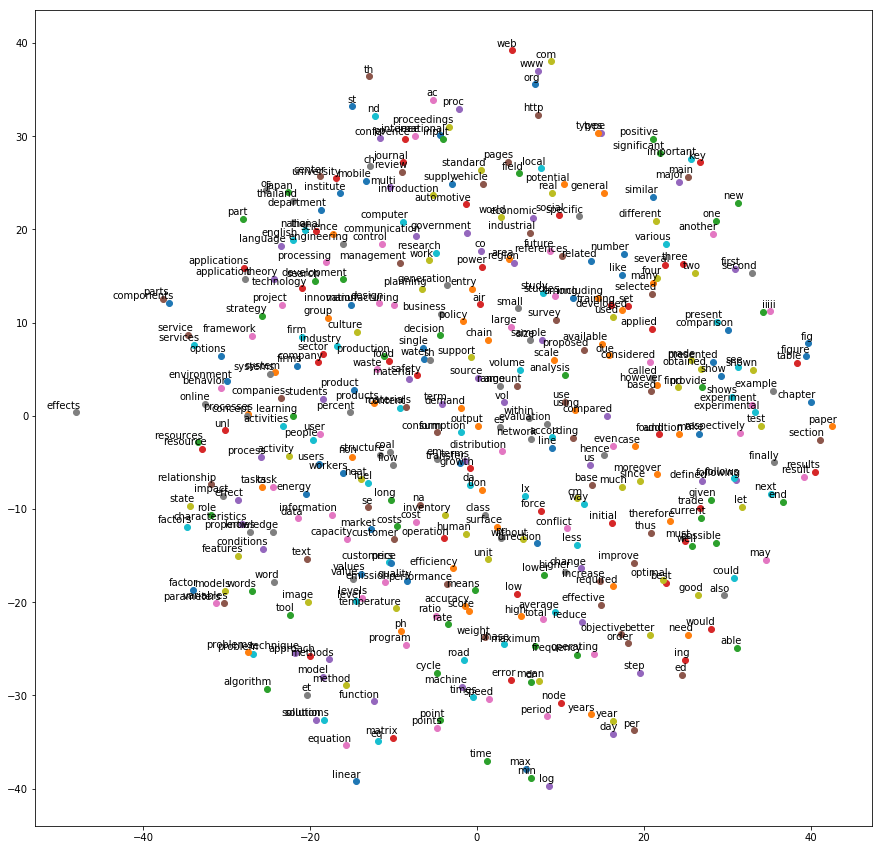

In [16]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)